<a href="https://colab.research.google.com/github/lapythie/ml/blob/master/HW01_ML_pandas_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pymorphy2[fast]

import pandas as pd
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from string import punctuation
punctuation += '«»—–…“”' #добавила среднее тире
morph = MorphAnalyzer()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

def normalize (text):
  normalized_text = [word.strip(punctuation) for word 
                     in text.lower().split() if word.strip(punctuation)]
  return normalized_text

In [ ]:
weather_hist = pd.read_csv('weatherHistory.csv')

###Предобработка (копипаст из семинара)

In [ ]:
weather_hist.rename({'Formatted Date':'date', 'Temperature (C)':'temp', 'Apparent Temperature (C)':'temp_app',
                    'Precip Type':'weather_type', 'Wind Speed (km/h)':'wind_speed', 'Humidity':'humidity',
                    'Daily Summary':'summary'}, 
                    axis=1, inplace=True)

In [ ]:
weather_hist['visibility'] = weather_hist['Visibility (km)']
weather_hist['wind_bearing'] = weather_hist['Wind Bearing (degrees)']
weather_hist['pressure'] = weather_hist['Pressure (millibars)']
weather_hist.drop(['Visibility (km)', 'Wind Bearing (degrees)', 'Pressure (millibars)'], axis=1, inplace=True)
#axis=0 for rows

In [ ]:
weather_hist.drop(['Loud Cover'], axis=1, inplace=True)

In [ ]:
weather_hist = weather_hist[weather_hist['pressure'] > 100]

In [ ]:
weather_hist[weather_hist['pressure'] < 100]['pressure'] = weather_hist['pressure'].mean()

### Дз, часть 1


*Проанализируйте данные и найдите самый холодный и самый ветренный дни в Сегеде за всю имеющуюся историю.*

In [ ]:
weather_hist['date'] = pd.to_datetime(weather_hist['date'], utc=True)

In [ ]:
weather_hist.dtypes['date']

datetime64[ns, UTC]

Непонятно, как определять холодность дня - по минимальной температуре или по средней температуре за день. На всякий случай нашла и то, и то. То же самое с самым ветреным днём.

In [ ]:
# самый холодный день за всю историю наблюдений
groups = [weather_hist.date.dt.year
          , weather_hist.date.dt.month
          , weather_hist.date.dt.day
          ]
weather_hist.groupby(by=groups, sort=False).agg('mean').idxmin()['temp']

(2012, 2, 10)

In [ ]:
#день, когда был зафиксирован температурный минимум
weather_hist.nsmallest(1, 'temp').date

54847   2012-02-10 06:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]

Самый холодный по средней температуре день оказался одновременно и днём с температурным минимумом.

То же самое для скорости ветра:

In [ ]:
# самый ветреный день за всю историю наблюдений
groups = [weather_hist.date.dt.year
          , weather_hist.date.dt.month
          , weather_hist.date.dt.day
          ]
weather_hist.groupby(by=groups, sort=False).agg('mean').idxmax()['wind_speed']

(2008, 1, 27)

In [ ]:
#день, когда был зафиксирован максимум по скорости ветра
weather_hist.nlargest(1, 'wind_speed').date.dt.date

12181    2007-01-29
Name: date, dtype: object

Сколько раз шёл дождь летом 2014 года? Всегда. Один сплошной раз:

In [ ]:
len(weather_hist[(weather_hist.date.dt.year == 2014)
              & (weather_hist.date.dt.month.between(6,8))
                 ].groupby(weather_hist.date.dt.dayofyear, sort=False))
# weather_hist['Summary'].value_counts()

92

In [ ]:
# самый ветреный месяц в году
weather_hist.groupby(weather_hist.date.dt.month, sort=False
                     ).agg('mean').idxmax()['wind_speed']

3

In [ ]:
# самый ветреный месяц за всю историю наблюдений
groups = [weather_hist.date.dt.year
          , weather_hist.date.dt.month
          ]
weather_hist.groupby(by=groups, sort=False
                     ).agg('nunique').idxmax()['Summary']

(2012, 3)

In [ ]:
# самый влажный год за всю историю наблюдений
weather_hist.groupby(weather_hist.date.dt.year, sort=False
                     ).agg('mean').idxmax()['humidity']

2005

Но за 2005 год есть только одна запись, нельзя по ней делать выводы:

In [ ]:
weather_hist.groupby(weather_hist.date.dt.year
                     ).agg('nunique').head(1)

,date,Summary,weather_type,temp,temp_app,humidity,wind_speed,summary,visibility,wind_bearing,pressure
date,,,,,,,,,,,
2005,1,1,1,1,1,1,1,1,1,1,1


Значит, на самом деле самый влажный год - 2010:

In [ ]:
weather_hist.groupby(weather_hist.date.dt.year
                     ).agg('mean').sort_values(by=['humidity'], 
                                               ascending=False).head(3)

,temp,temp_app,humidity,wind_speed,visibility,wind_bearing,pressure
date,,,,,,,
2005,0.577778,-4.050000,0.890000,17.114300,9.982000,140.000000,1016.660000
2010,11.177522,10.073168,0.796993,11.005474,9.129442,192.116856,1014.167393
2006,11.104832,10.034645,0.768657,10.146414,9.765750,188.889410,1018.591666


In [ ]:
# неделя с самой переменчивой погодой
groups = [weather_hist.date.dt.year
          , weather_hist.date.dt.weekofyear
          ]
weather_hist.groupby(by=groups, sort=False).agg('nunique').idxmax()['Summary']


(2007, 5)

## Дз, часть 2

*Попробуйте придумать признаки (как минимум 5), которые можно извлечь из текста, помимо тех 4, которые мы уже использовали. Обучите модель на них и проверьте, улучашается ли качество. Опишите признаки, которое придумали и почему считаете, что они должны показывать вероятность покупки.*

*Побробуйте подобрать параметры векторизатора (TfidfVectorizer или CountVectorizer, или обоих) и параметры алгоритма так, чтобы качество, которое у нас получилось (0.248) улучшилось. Опишите то, что попробовали.*

In [ ]:
# data = pd.read_csv('train.csv.zip')
# так выкидываются строчки с пропусками в колонке description
# data.dropna(subset=['description'], inplace=True)
# data = data.sample(frac=0.1)
# data.to_csv('data.csv', index=None)

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.shape

(138715, 18)

In [ ]:
data.groupby(['category_name']).mean().idxmax()['deal_probability']
# категория в которой чаще совершаются сделки или типа того?

'Предложение услуг'

In [ ]:
%%time
description_words = Counter()
# частотник слов из объявлений с высокой deal_probability
# не знаю, зачем; смысла у этого нет
for row in data[data.deal_probability == 1].itertuples():
    for word2lemmatize in normalize(row.description):
      lemma = morph.parse(word2lemmatize)[0].normal_form
      description_words += Counter({lemma})

CPU times: user 8.07 s, sys: 2.32 ms, total: 8.07 s
Wall time: 8.09 s


In [ ]:
counter_df = pd.DataFrame.from_dict(description_words, orient='index').reset_index()
counter_df.rename({'index':'word', 0:'count'}, 
                    axis=1, inplace=True)

In [ ]:
counter_df['word_len'] = counter_df['word'].apply(len)

In [ ]:
counter_df['pos'] = counter_df['word'].apply(lambda x: morph.parse(x)[0].tag.POS)

In [ ]:
counter_df[(counter_df['pos'].isnull())
           & (counter_df['count'] == 1)
           & (counter_df['word_len'] < 3)
           ].sort_values(by='count',
                         ascending=False).head(5)

,word,count,word_len,pos
302,цо,1,2,None
5573,гп,1,2,None
4549,ца,1,2,None
4585,2д,1,2,None
4587,4д,1,2,None


In [ ]:
# dropping rare and meaningless tokens

# indexNames = counter_df[(counter_df['pos'].isnull())
#            & (counter_df['count'] == 1)
#            & (counter_df['word_len'] < 3)].index

# counter_df.drop(indexNames , inplace=True)

In [ ]:
counter_df[(counter_df['pos'] == 'NOUN')
           & (counter_df['word_len'] > 3)
           ].sort_values(['count'], ascending=False).head(50)

### Тут смотрю корреляцию вероятности сделки со всякими бессмысленными признаками

Можно сразу переходить к ctrl-f, **Попытки предсказать вероятность сделки по тексту описания**

#### Частые глаголы

In [ ]:
freq_infinitives = []

for row in counter_df[
           (counter_df['pos'] == ('INFN' or 'VERB'))
           & 
           (counter_df['word_len'] > 3)
           &
           (counter_df['count'] > 10)
].itertuples():
    freq_infinitives.append(row.word)

freq_infinitives

In [ ]:
# выбрала самые добрые
freq_infinitives = [
 'звонить',
 'договориться',
 'помочь',
 'входить',
 'гарантировать',
 'приглашать',
 ]

In [ ]:
data['n_verbs'] = data['description'].apply(lambda x: len([word for word in normalize(x) if morph.parse(word)[0].normal_form in freq_infinitives]))

In [ ]:
data.groupby(data['n_verbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs,8_adverbs,n_nouns,n_verbs
n_verbs,,,,,,,,,,,,
0,248036.411704,674.705211,1240.887874,0.144945,167.938271,23.714178,7.463546,33.948595,0.035429,0.047619,0.107552,0.0
1,633575.552195,2291.494479,1604.371033,0.155384,494.705166,69.534332,26.133266,111.490925,0.158903,0.216398,0.575073,1.0
2,484811.504294,2139.740385,1712.034965,0.163324,878.385684,124.810897,55.261752,199.076923,0.308761,0.469017,1.013889,2.0
3,275240.017857,2064.766667,1683.348837,0.131699,1443.500000,212.577778,97.472222,384.727778,0.661111,0.900000,1.416667,3.0
4,598320.562500,1298.500000,1832.812500,0.246768,1852.500000,281.937500,113.812500,451.750000,0.562500,0.625000,1.312500,4.0
5,2195.000000,938.333333,1849.000000,0.066667,1212.333333,185.333333,76.666667,304.666667,0.500000,0.500000,1.166667,5.0
6,2500.000000,292.000000,1987.500000,0.432600,1556.000000,211.000000,39.500000,372.500000,0.000000,0.000000,0.000000,6.0


In [ ]:
data['n_verbs'].corr(data['deal_probability'])
# 0.0030058545646154534

In [ ]:
# data.loc[data['n_verbs'] > 3, 'n_verbs'] = 0

#### Четыре частых существительных

In [ ]:
freq_nouns = []

for row in counter_df[
           (counter_df['pos'] == 'NOUN')
           & 
           (counter_df['word_len'] > 3)
           &
           (counter_df['count'] > 40)
].itertuples():
    freq_nouns.append(row.word)

freq_nouns

In [ ]:
# выбрала самые добрые
# люба это любой, видимо
freq_nouns = [
 'опыт',
 'гарантия',
 'любой',
 'люба',
 'качество',
 'скидка',
 'помощь'
 ]

In [ ]:
data['n_nouns'] = data['description'].apply(lambda x: len([word for word in normalize(x) if morph.parse(word)[0].normal_form in freq_nouns]))

In [ ]:
data.groupby(data['n_nouns']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs,8_adverbs
n_nouns,,,,,,,,,,
0,2.626589e+05,618.677627,1226.808386,0.144907,152.477186,21.635093,6.532870,30.271697,0.027446,0.037163
1,3.852756e+05,2144.884867,1539.621865,0.152561,403.124478,56.088278,20.533478,88.757848,0.125658,0.176828
2,2.432406e+05,1970.779960,1680.806479,0.158967,730.768337,103.007615,41.331864,166.691784,0.289379,0.391182
3,1.273543e+05,2030.425481,1744.949559,0.145216,997.110577,140.068510,59.442308,231.921875,0.486779,0.625000
4,1.855503e+05,2350.913621,1777.374570,0.133074,1299.285714,183.395349,79.126246,315.790698,0.604651,0.797342
5,2.002918e+05,1961.315152,1452.615854,0.083991,1634.290909,216.309091,123.800000,477.242424,0.551515,0.666667
6,7.700917e+04,1575.400000,1762.617647,0.149125,1580.142857,228.942857,135.314286,349.085714,0.800000,0.971429
7,2.156483e+05,417.076923,1820.256410,0.112027,1814.692308,253.538462,179.358974,404.102564,1.025641,1.153846
8,1.074135e+05,100.400000,1345.100000,0.163842,1833.400000,259.300000,78.800000,420.400000,0.800000,1.100000


In [ ]:
data['n_nouns'].corr(data['deal_probability'])
# 0.0030058545646154534 - глаголы

0.007326306359846318

In [ ]:
data.loc[data['n_nouns'] > 4, 'n_nouns'] = 0

In [ ]:
data.groupby(data['n_adverbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum
n_adverbs,,,,,,,,
0,264491.128292,738.455382,1253.905449,0.144329,175.786463,24.847430,8.049753,36.035371
1,514518.027108,1906.457442,1545.193886,0.174220,585.253685,81.677366,27.532573,126.203281
2,163338.309630,1360.743462,1693.048295,0.196908,847.513076,120.383562,57.027397,203.742217
3,75675.977011,1296.642512,1410.118280,0.223429,924.067633,131.966184,44.913043,201.545894


In [ ]:
data[data.n_adverbs < 4].corr()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs
price,1.000000,0.077973,0.046540,-0.015032,0.070124,0.066481,0.017722,0.056030,0.006224
item_seq_number,0.077973,1.000000,0.093411,-0.038196,0.117144,0.112789,0.079725,0.127046,0.029837
image_top_1,0.046540,0.093411,1.000000,0.185397,0.184829,0.182593,0.150551,0.174994,0.056400
deal_probability,-0.015032,-0.038196,0.185397,1.000000,-0.009304,-0.013111,-0.012485,-0.023144,0.026812
text_len,0.070124,0.117144,0.184829,-0.009304,1.000000,0.989847,0.612836,0.944754,0.303412
text_len_tokens,0.066481,0.112789,0.182593,-0.013111,0.989847,1.000000,0.618434,0.938101,0.304664
number_of_caps,0.017722,0.079725,0.150551,-0.012485,0.612836,0.618434,1.000000,0.628858,0.191720
number_of_nonalphanum,0.056030,0.127046,0.174994,-0.023144,0.944754,0.938101,0.628858,1.000000,0.290123
n_adverbs,0.006224,0.029837,0.056400,0.026812,0.303412,0.304664,0.191720,0.290123,1.000000


#### Пять частых наречий

In [ ]:
freq_adverbs = []

for row in counter_df[
           (counter_df['pos'] == 'ADVB')
           & 
           (counter_df['word_len'] > 3)
           &
           (counter_df['count'] > 28)
].itertuples():
    freq_adverbs.append(row.word)

freq_adverbs

In [ ]:
data['n_adverbs'] = data['description'].apply(lambda x: len([word for word in normalize(x) if morph.parse(word)[0].normal_form in freq_adverbs]))

In [ ]:
data.groupby(data['n_adverbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum
n_adverbs,,,,,,,,
0,264533.528401,738.233180,1253.661254,0.144329,175.241806,24.770259,8.018884,35.904126
1,514518.027108,1906.457442,1545.193886,0.174220,585.253685,81.677366,27.532573,126.203281
2,163338.309630,1360.743462,1693.048295,0.196908,847.513076,120.383562,57.027397,203.742217
3,75675.977011,1296.642512,1410.118280,0.223429,924.067633,131.966184,44.913043,201.545894
4,209832.000000,1489.184211,1914.540541,0.113502,1461.500000,204.763158,83.710526,352.342105
5,2488.800000,842.454545,1815.636364,0.303793,1529.000000,228.090909,94.454545,349.363636
7,190.000000,1221.500000,1200.000000,0.000000,2351.500000,335.500000,127.500000,591.500000
17,21100.000000,241.000000,1152.000000,0.000000,2335.000000,320.000000,37.000000,480.000000
35,23500.000000,250.000000,901.000000,0.000000,2605.000000,334.000000,34.000000,529.000000


In [ ]:
data['n_adverbs'].corr(data['deal_probability'])

0.023196750093905243

In [ ]:
data.loc[data['n_adverbs'] > 3, 'n_adverbs'] = 0

In [ ]:
data.groupby(data['n_adverbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum
n_adverbs,,,,,,,,
0,264491.128292,738.455382,1253.905449,0.144329,175.786463,24.847430,8.049753,36.035371
1,514518.027108,1906.457442,1545.193886,0.174220,585.253685,81.677366,27.532573,126.203281
2,163338.309630,1360.743462,1693.048295,0.196908,847.513076,120.383562,57.027397,203.742217
3,75675.977011,1296.642512,1410.118280,0.223429,924.067633,131.966184,44.913043,201.545894


In [ ]:
data[data.n_adverbs < 4].corr()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs
price,1.000000,0.077973,0.046540,-0.015032,0.070124,0.066481,0.017722,0.056030,0.006224
item_seq_number,0.077973,1.000000,0.093411,-0.038196,0.117144,0.112789,0.079725,0.127046,0.029837
image_top_1,0.046540,0.093411,1.000000,0.185397,0.184829,0.182593,0.150551,0.174994,0.056400
deal_probability,-0.015032,-0.038196,0.185397,1.000000,-0.009304,-0.013111,-0.012485,-0.023144,0.026812
text_len,0.070124,0.117144,0.184829,-0.009304,1.000000,0.989847,0.612836,0.944754,0.303412
text_len_tokens,0.066481,0.112789,0.182593,-0.013111,0.989847,1.000000,0.618434,0.938101,0.304664
number_of_caps,0.017722,0.079725,0.150551,-0.012485,0.612836,0.618434,1.000000,0.628858,0.191720
number_of_nonalphanum,0.056030,0.127046,0.174994,-0.023144,0.944754,0.938101,0.628858,1.000000,0.290123
n_adverbs,0.006224,0.029837,0.056400,0.026812,0.303412,0.304664,0.191720,0.290123,1.000000


#### Восемь частых наречий

In [ ]:
freq_adverbs = []
# они и так самые добрые, вручную не стала выбирать
for row in counter_df[
           (counter_df['pos'] == 'ADVB')
           & 
           (counter_df['word_len'] > 3)
           &
           (counter_df['count'] > 15)
].itertuples():
    freq_adverbs.append(row.word)

freq_adverbs

['бесплатно',
 'более',
 'качественно',
 'дорого',
 'круглосуточно',
 'быстро',
 'всегда',
 'недорого']

In [ ]:
data['8_adverbs'] = data['description'].apply(lambda x: len([word for word in normalize(x) if morph.parse(word)[0].normal_form in freq_adverbs]))

In [ ]:
data.groupby(data['8_adverbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs,8_adverbs
8_adverbs,,,,,,,,,,
0,261300.896916,678.910080,1247.966579,0.144233,170.310058,24.080617,7.652658,34.585595,0.000000,0.0
1,519935.794877,2791.475567,1575.380627,0.168767,539.740550,75.317536,27.587682,119.715656,0.714549,1.0
2,318540.951351,2562.752984,1680.642558,0.184938,869.218549,122.458219,53.489440,209.057851,1.516070,2.0
3,115951.817121,1258.848993,1504.749064,0.232307,967.862416,138.124161,53.392617,217.087248,2.486577,3.0
4,129772.200000,1581.222222,2039.309278,0.087359,1367.151515,201.777778,95.808081,316.282828,1.585859,4.0
5,3565.294118,1933.611111,1763.666667,0.205311,1725.333333,241.111111,118.388889,512.000000,0.388889,5.0
6,27563.636364,244.250000,2607.000000,0.066667,1714.166667,239.166667,117.416667,426.250000,0.166667,6.0
7,190.000000,1221.500000,1200.000000,0.000000,2351.500000,335.500000,127.500000,591.500000,0.000000,7.0
17,21100.000000,241.000000,1152.000000,0.000000,2335.000000,320.000000,37.000000,480.000000,0.000000,17.0


In [ ]:
data['8_adverbs'].corr(data['deal_probability'])

0.020438750639709086

In [ ]:
data.loc[data['8_adverbs'] > 3, '8_adverbs'] = 0

In [ ]:
data.groupby(data['8_adverbs']).mean()

,price,item_seq_number,image_top_1,deal_probability,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,n_adverbs
8_adverbs,,,,,,,,,
0,261138.703203,679.720632,1248.803370,0.144187,171.628930,24.272484,7.746158,34.913369,0.000000
1,519935.794877,2791.475567,1575.380627,0.168767,539.740550,75.317536,27.587682,119.715656,0.714549
2,318540.951351,2562.752984,1680.642558,0.184938,869.218549,122.458219,53.489440,209.057851,1.516070
3,115951.817121,1258.848993,1504.749064,0.232307,967.862416,138.124161,53.392617,217.087248,2.486577


In [ ]:
data['8_adverbs'].corr(data['deal_probability'])

0.02674262531307089

## Попытки предсказать вероятность сделки по тексту описания

In [ ]:
# data.loc[0:,'normal_punct_count':].to_pickle('10_new_columns.pkl')  # where to save it, usually as a .pkl
# new_columns_df = pd.read_pickle('10_new_columns.pkl')
# data = pd.concat([data,new_columns_df], axis=1)

In [ ]:
# из семинара
data['text_len'] = data['description'].apply(len)
data['text_len_tokens'] = data['description'].apply(lambda x: len(x.split()))
data['number_of_caps'] = data['description'].apply(lambda x: len([ch for ch in x if ch.isupper()]))
data['number_of_nonalphanum'] = data['description'].apply(lambda x: len([ch for ch in x if not ch.isalnum()]))

### 5 моих признаков

In [ ]:
# количество слов на латинице к общему количеству слов
data['latin_count'] = data['\
description'].apply(lambda x: len([word for word in normalize(x) if 'LATN' \
                                   in morph.parse(word)[0].tag]))

# количество уникальных слов
data['rare_words_count'] = data['description'].apply(
    lambda x: len([word for word in normalize(x) 
    if len(counter_df[
                      (counter_df['word'] == 
                       morph.parse(word)[0].normal_form)
                       & (counter_df['count'] == 1)
                       ]
           ) == 1]))
# # нормированное количество уникальных слов
data['norm_rare_words_count'] = data.apply(lambda x: x['rare_words_count']\
                                           /x['text_len_tokens'], axis=1)

# # количество прилагательных
data['adjectives_count'] = data['\
description'].apply(lambda x: len([word for word in normalize(x) \
                                   if morph.parse(word)[0].tag.POS == ('ADJF' or 'ADJS')]))

# # количество знаков препинания, нормированное на длину текста
data['normal_punct_count'] = data['\
description'].apply(lambda x: len([ch for ch in x \
                                   if ch in punctuation])/len(x))

# # средняя длина предложения в токенах
data['sent_len'] = data['\
description'].apply(lambda x: sum([len(normalize(sent)) for sent \
                                   in sent_tokenize(x)])/len(sent_tokenize(x)))

In [ ]:
# col_names = ['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum']
# for col_name in col_names:
#   print (col_name, data[col_name].corr(data['deal_probability']))

In [ ]:
col_names = 'latin_count norm_rare_words_count \
adjectives_count normal_punct_count sent_len'.split()
for col in ['text_len', 'text_len_tokens', 
            'number_of_caps', 'number_of_nonalphanum']:
  col_names.append(col)
X = data[col_names].values
y = data.deal_probability.values
X.shape

(138715, 9)

Обучение на 5 новых колонках и на 5 колонках с семинара:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
regressor = Ridge(alpha=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.26302796466849976

In [ ]:
regressor = Lasso(alpha=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
mean_absolute_error(y_test, preds)

0.1956687769437188

*Побробуйте подобрать параметры векторизатора (TfidfVectorizer или CountVectorizer, или обоих) и параметры алгоритма так, чтобы качество, которое у нас получилось (0.248) улучшилось. Опишите то, что попробовали.*

In [ ]:
cv = CountVectorizer(max_features=2000, min_df=20, max_df=0.4, ngram_range=(1,1))
X = cv.fit_transform(data.description)
y = data.deal_probability.values

In [ ]:
# cv.get_feature_names()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
regressor = Ridge(alpha=10)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

# ngram_range=(1,2)
# CountVectorizer(max_features=1000 - 0.2512515450632489
# CountVectorizer(max_features=2000 - 0.25090102061975766
# CountVectorizer(max_features=3000 - 0.25091653581703155

# ngram_range=(2,3)
# CountVectorizer(max_features=3000 - 0.2548935910465992
# CountVectorizer(max_features=2000 - 0.25493479345179293

# ngram_range=(1,1) - 0.2507790649081902
# max_features=2000

# ngram_range=(1,1)
# max_features=2000
# min_df=20 - 0.25077530130898984

0.25077530130898984

In [ ]:
cv = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.4)
X = cv.fit_transform(data.description)
y = data.deal_probability.values

# 0.24837197234438146 alpha=1 1000 features
# 0.24808644386195344 alpha=11 1000 features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
regressor = Ridge(alpha=11) #1
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.24808644386195344

In [ ]:
regressor = SGDRegressor(max_iter=100, alpha=0.00001)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))
#max_iter=10

0.2524151319031154

### Описание того, что попробовала

Взяла все объявления с deal_probability равным единице. Сделала частотник их словаря.

Придумала признаки:


1.   количество токенов на латинице - тег LATN в пайморфи.

2.   доля редких слов - счётчик слова равен единице

3.   количество прилагательных - теги ADJF и ADJS в пайморфи

4.   доля символов, которые относятся к пунктуации

5.   средняя длина предложения в токенах

**Я не считаю, что эти признаки должны показывать вероятность покупки. Но всё равно попробую это доказать:**

1.   Большое количество токенов на латинице должно смутить потенциального покупателя - лет ми спик фром май харт, не всем людям такие токены что-то говорят. Или, по-другому: токены на латинице (при условии, что они имеют отношение к товару и услуге) говорят о том, что продавец ответственно подошёл к описанию. Например, указал модель кухонной техники. Так, более понятным и заслуживающим доверия, чем просто "чайник", может выглядеть объявление "чайник Melissa".
2.   Доля редких слов может указывать либо на то, продавец добавил в описание лишнюю информацию. Редкие несловарные слова могут появиться из-за нарушений правил правописания, что могло бы уменьшить вероятность сделки с привередливым покупателем.
3.   Количество прилагательных, возможно, говорит о том, насколько продавец постарался расхвалить товар. ОТЛИЧНЫЙ КОМПАКТНЫЙ МОЩНЫЙ КРАСИВЫЙ ЧАЙНИК, предположительно, увеличит вероятность сделки с доверчивым покупателем.
4.   Доля пунктуационных знаков может говорить о том, насколько корректно продавец использует пунктуацию. Объявление из 1000 символов, в котором нет ни одной точки или запятой, настораживает. С другой стороны, большая доля пунктуации может свидетельствовать лишь о любви продавца к восклицательным знакам!!!!!!!!!!!!!!!!
5.   Средняя длина предложения в токенах также, предположительно, может что-то говорить о том, как построен текст. Если предложения очень длинные, такой текст может быть сложен для понимания, и тем самым, возможно, отпугнёт занятого покупателя, который хотел бы быстро узнать всё необходимое о товаре.

Качество модели, обученной по этим пяти признакам, незначительно хуже качества модели, обученной по исходным четырём.

# Trash

In [ ]:
weather_hist.loc[:0, :'temp']

,date,Summary,weather_type,temp
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222


In [ ]:
weather_hist.iloc[0:1, 1:]

,Summary,weather_type,temp,temp_app,humidity,wind_speed,summary,visibility,wind_bearing,pressure
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,Partly cloudy throughout the day.,15.8263,251.0,1015.13


###Статистики с семинара

Посмотреть все колонки датасета можно вот так

In [ ]:
weather_hist.describe(include=['object'])
weather_hist.info()
weather_hist['date'].value_counts()
# метод corr считает корреляцию всех колонок со всеми (острожнее, если у вас большой датасет)
weather_hist.corr()

Для наглядности можно нарисовать тепловую карту.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

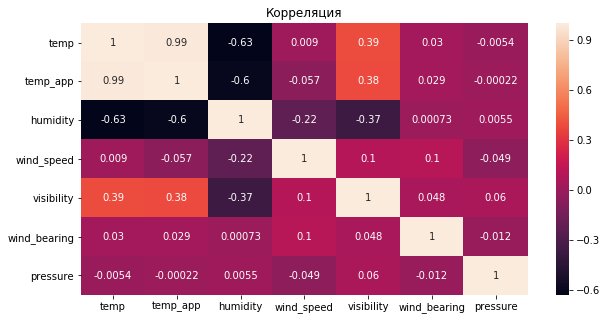

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=weather_hist.corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

Ещё можно нарисовать ящик с усами для каждой из колонок, чтобы посмотреть, нет ли в данных выбросов:

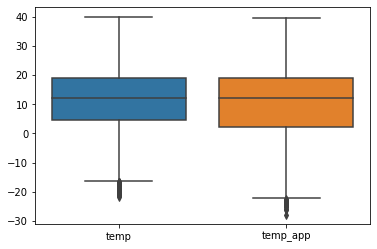

In [ ]:
ax = sns.boxplot(data=weather_hist[['temp', 'temp_app']])